In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Load Dataset
data = pd.read_csv('C:/Users/Admin/Desktop/creditcard.csv')  # Update path if needed
print(data.head())

# Data Preprocessing
scaler = StandardScaler()
X = data.drop(columns=['Class'])  # Features
y = data['Class']  # Target

X_scaled = scaler.fit_transform(X)  # Normalize features
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))  # Reshape for LSTM

# Split into Train & Test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training Samples: {X_train.shape}, Test Samples: {X_test.shape}")


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - accuracy: 0.9979 - loss: 0.0757 - val_accuracy: 0.9982 - val_loss: 0.0048
Epoch 2/20
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9987 - loss: 0.0042 - val_accuracy: 0.9994 - val_loss: 0.0041
Epoch 3/20
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9993 - loss: 0.0036 - val_accuracy: 0.9993 - val_loss: 0.0038
Epoch 4/20
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9994 - loss: 0.0031 - val_accuracy: 0.9994 - val_loss: 0.0042
Epoch 5/20
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9994 - loss: 0.0027 - val_accuracy: 0.9994 - val_loss: 0.0039
Epoch 6/20
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9994 - loss: 0.0025 - val_accuracy: 0.9994 - val_loss: 0.0038
Epoch 7/20
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9995 - loss: 0.0027 - val_accuracy: 0.9994 - val_loss: 0.0045
Epoch 8/20
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9995 - loss: 0

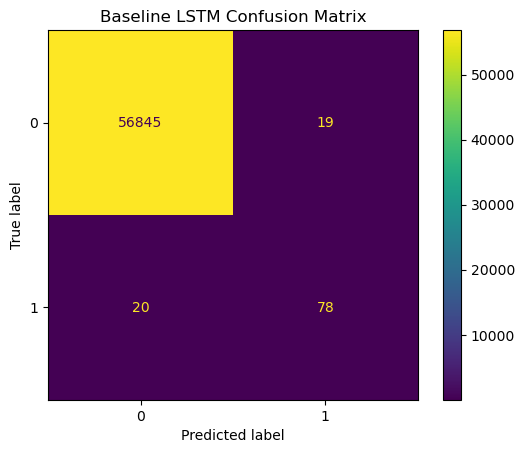

In [3]:
# Build Baseline LSTM Model
def build_baseline_lstm(input_shape):
    model = Sequential([
        LSTM(64, activation='relu', input_shape=input_shape, return_sequences=True),
        Dropout(0.3),
        LSTM(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train Baseline LSTM
baseline_lstm = build_baseline_lstm((X_train.shape[1], X_train.shape[2]))

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_baseline = baseline_lstm.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate Baseline LSTM
y_pred_baseline = (baseline_lstm.predict(X_test) > 0.5).astype(int).flatten()
print("\nBaseline LSTM Performance:")
print(classification_report(y_test, y_pred_baseline))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_baseline))

# Plot Baseline Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_baseline))
disp.plot()
plt.title("Baseline LSTM Confusion Matrix")
plt.show()